# Text Generation with RNNs

In this notebook we use the components developed in `modelling.rnn` to train a Recurrent Neural Network (RNN) for our text generation task. RNNs are easier to train than models based on transformers and can such serve as a useful benchmark.

## Imports

The bulk of the code required to setup, train and generate new text from the model, is contained within `modelling.rnn` (check the source code for the details). We import this module together with others that serve the training data and manage model persistence.

In [1]:
from textwrap import wrap

from torch.utils.data import DataLoader

from modelling import data as data
from modelling import rnn as rnn
from modelling import utils as utils

## Model and Training Parameters

Configure hyper-parameters for the model and the training routine.

In [2]:
MODEL_NAME = "lstm_next_word_gen"

SIZE_EMBED = 256
SIZE_HIDDEN = 512

N_EPOCHS = 20
BATCH_SIZE = 256
SEQ_LEN = 40
MIN_WORD_FREQ = 2
LEARNING_RATE = 0.005

## Setup Training Data

In [3]:
dataset = data.FilmReviewSequences(split="all", seq_len=SEQ_LEN, min_freq=MIN_WORD_FREQ)
data_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    collate_fn=data.pad_seq2seq_data
)

## Instantiate Model

In [4]:
model = rnn.NextWordPredictionRNN(dataset.vocab_size, SIZE_EMBED, SIZE_HIDDEN)
model

NextWordPredictionRNN(
  (_embedding): Embedding(63223, 256)
  (_lstm): LSTM(256, 512, batch_first=True)
  (_linear): Linear(in_features=512, out_features=63223, bias=True)
)

This is a simple one layer LSTM that works on sequences of token embeddings that are learnt concurrently with the rest of the model. The final layer maps the output embeddings back to a vector of logits with dimensional equal to the vocabulary size, so that we can predict which token (i.e, category) the next word in the sequence belongs to.

## Train

In [5]:
train_losses = rnn.train(model, data_loader, N_EPOCHS, LEARNING_RATE)
utils.save_model(model, name=MODEL_NAME, loss=min(train_losses.values()))

epoch 2 current loss = 4.8847: 100%|██████████| 195/195 [1:12:08<00:00, 22.20s/it] 



best model:
|-- epoch: 2
|-- loss: 4.8847


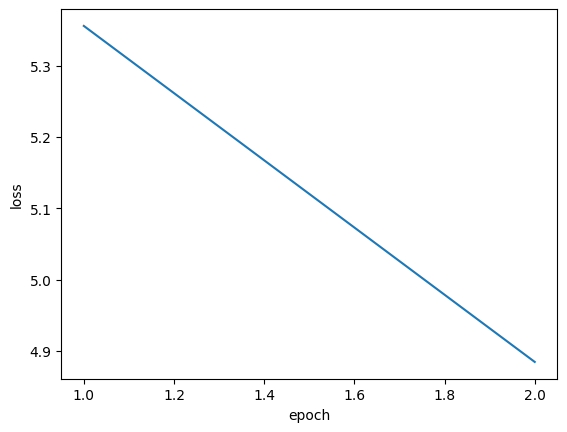

In [6]:
utils.plot_train_losses(train_losses)

## Generate Text with Model

Start by loading a model and instantiating a tokeniser that can also map from tokens back to text. The `load_model` function will load the best performing model that has been persisted on the local filesystem.

In [7]:
tokenizer = data.IMDBTokenizer()
best_model: rnn.NextWordPredictionRNN = utils.load_model(MODEL_NAME)

loading .models/lstm_next_word_gen/trained@2023-06-30T03:22:57;loss=2_5923.pt


Now pass a prompt to the model and get it to generate the text that comes after.

In [8]:
prompt = "I thought this movie was"
text = rnn.generate(best_model, prompt, tokenizer, temperature=2.0)

for line in wrap(text, width=89):
    print(line)

==> I THOUGHT THIS MOVIE WAS great. I mean it s not even a good movie but it is a great
film. The acting is good but the execution is appallingly acted and the story is about a
mercenary boy sean connery who seems to be the kind of relationship between the struggles
of the characters. No real suspense. The plot is...


And compare this output with that from an untrained model.

In [9]:
untrained_model = rnn.NextWordPredictionRNN(dataset.vocab_size, SIZE_EMBED, SIZE_HIDDEN)
text = rnn.generate(untrained_model, prompt, tokenizer, temperature=2.0)

for line in wrap(text, width=89):
    print(line)

==> I THOUGHT THIS MOVIE WAS scoutmaster magnetic meaney julliard chrissy liven raju
mcmansions coneheads sh_it huac harding shelby draw liquids gratified cass mayer overs
perú deflate approx escapee gouged rodriquez terrestial pressburger safes sloshed
transient manji daimajin sumatra concludes mili leitch burtonesque nudged chromosomes
tearjerker beaned insidious interloper cartland duchovney vie drown cheshire shrews
peacecraft woodman brueghel stimuli adventuring continental described newsreels ballast
kara hitlerian...
